In [1]:
import os

# Select the backend before importing folps.py
os.environ["FOLPS_BACKEND"] = "numpy"  #'numpy' or 'jax'

from folps_newtest import *
from cosmo_class import *
from use_fkpt import *

✅ Using NumPy with CPU.


In [2]:
#omega_i = Omega_i h² 
omega_b = 0.022;        #baryons
omega_cdm = 0.122;       #CDM
omega_ncdm = 0.0006442;    #massive neutrinos 
h = 0.6711;                 #h = H0/100
z_pk = 0.3;  #evaluation redshift
z_pk_scale = 0.97
CosmoParams = [z_pk, omega_b, omega_cdm, omega_ncdm, h]

In [3]:
%%time
#linear power spectrum
ps = generate_ps(h = 0.6711, ombh2 = 0.022, omch2 = 0.122, omnuh2 = 0.0006442, 
            As = 2e-9, ns = 0.965, z = z_pk, z_scale=[0.97],
            N_ur = 2.0328,
            khmin = 0.0001, khmax = 2.0, nbk = 1000, spectra = 'matter')
inputpkT = np.array([ps['kh'], ps['pk']])
kwargs = {'z': z_pk, 'f0':0.6900011469771554, 'h': h}

CPU times: user 1.58 s, sys: 12.8 ms, total: 1.6 s
Wall time: 228 ms


In [4]:
matrix = MatrixCalculator(A_full=True)
mmatrices = matrix.get_mmatrices()

Loading matrices from matrices_nfftlog128_AfullTrue.npy


In [5]:
%%time
#1-loop
nonlinear = NonLinearPowerSpectrumCalculator(mmatrices=mmatrices,
                                             kernels='fk',
                                             **kwargs)

CPU times: user 207 µs, sys: 9 µs, total: 216 µs
Wall time: 210 µs


In [6]:
kwargs = {'z': z_pk, 'h': h, 'Omega_m': ps['cosmo'].Omega0_m(), 'f0':0.6900011469771554,
          #'f0':classy['cosmo'].scale_independent_growth_factor_f(z_pk)
         }

In [10]:
%%time
table, table_now = nonlinear.calculate_loop_table(k=inputpkT[0], pklin=inputpkT[1], cosmo=ps['cosmo'],
                                             **kwargs)

CPU times: user 106 ms, sys: 8.39 ms, total: 114 ms
Wall time: 58.9 ms


In [11]:
# Bias parameters
b1 = 1.70               
b2 = -0.45
bs2 = -4/7*(b1 - 1)
b3nl = 32/315*(b1 - 1)
# EFT parameters
alpha0 = 3.0               #units: [Mpc/h]^2              
alpha2 = -29.0             #units: [Mpc/h]^2
alpha4 = 0.0               #units: [Mpc/h]^2
ctilde = 0.0               #units: [Mpc/h]^4
# Stochatic parameters
PshotP = 5000
alphashot0 = 0.08
alphashot2 = -8.0          #units: [Mpc/h]^2
pars = [b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, ctilde, alphashot0, alphashot2, PshotP]
qpar, qper = 1., 1.


k = np.logspace(np.log10(0.01), np.log10(0.3), num=100) # array of  output k in [h/Mpc]

In [12]:
%%time
multipoles = RSDMultipolesPowerSpectrumCalculator(model='EFT')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 4.53 µs


In [13]:
%%time
P0, P2, P4  = multipoles.get_rsd_pkell(kobs=k, qpar=qpar, qper=qper, pars=pars, table=table, table_now=table_now)

CPU times: user 11.1 ms, sys: 0 ns, total: 11.1 ms
Wall time: 10.9 ms


In [14]:
%%time
P0_noir, P2_noir  = multipoles.get_rsd_pkell(kobs=k, qpar=qpar, qper=qper, pars=pars, table=table, table_now=table_now, ells=(0, 2),IR_resummation=False)

CPU times: user 3.74 ms, sys: 0 ns, total: 3.74 ms
Wall time: 3.21 ms


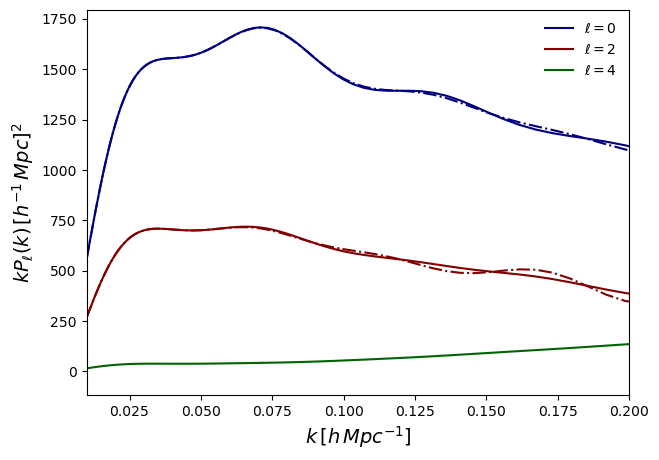

In [15]:
import matplotlib
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(7,5))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'$k P_{\ell}(k) \, [h^{-1} \,  Mpc]^2$', fontsize =  14)

axs.plot(k, k * P0, color = 'navy', ls='-', label=r'$\ell = 0$')
axs.plot(k, k * P0_noir, color = 'navy', ls='-.')

axs.plot(k, k * P2, color = 'maroon', ls='-', label=r'$\ell = 2$')
axs.plot(k, k * P2_noir, color = 'maroon', ls='-.')
axs.plot(k, k * P4, color = 'darkgreen', ls='-', label=r'$\ell = 4$')

axs.set_xlim([k[0], 0.2])
#axs.set_ylim([-200.0, 1800])

leg1 = axs.legend(loc = 'best');
leg1.get_frame().set_linewidth(0.0);

plt.show()

In [16]:
multipoles.model

'EFT'

In [17]:
len(table)

34

In [76]:
table[31]

array([-1.73986880e-04, -2.15599254e-04, -2.67178168e-04, -3.31110098e-04,
       -4.10351561e-04, -5.08564259e-04, -6.30281702e-04, -7.81114775e-04,
       -9.68005450e-04, -1.19953968e-03, -1.48633241e-03, -1.84150029e-03,
       -2.28124133e-03, -2.82554559e-03, -3.49906705e-03, -4.33219185e-03,
       -5.36234406e-03, -6.63557696e-03, -8.20850760e-03, -1.01506673e-02,
       -1.25473566e-02, -1.55031095e-02, -1.91458838e-02, -2.36321097e-02,
       -2.91527500e-02, -3.59405601e-02, -4.42787782e-02, -5.45115107e-02,
       -6.70560974e-02, -8.24177502e-02, -1.01206784e-01, -1.24158818e-01,
       -1.52158400e-01, -1.86266574e-01, -2.27752879e-01, -2.78132164e-01,
       -3.39206536e-01, -4.13112754e-01, -5.02375458e-01, -6.09966670e-01,
       -7.39371670e-01, -8.94660794e-01, -1.08056597e+00, -1.30256039e+00,
       -1.56693983e+00, -1.88090384e+00, -2.25263433e+00, -2.69136697e+00,
       -3.20744799e+00, -3.81236790e+00, -4.51876396e+00, -5.34038469e+00,
       -6.29200963e+00, -

In [78]:
table_now[31]

array([-1.66350799e-04, -2.06055710e-04, -2.55242101e-04, -3.16170822e-04,
       -3.91639428e-04, -4.85108481e-04, -6.00857168e-04, -7.44174854e-04,
       -9.21596653e-04, -1.14119285e-03, -1.41292412e-03, -1.74907714e-03,
       -2.16479809e-03, -2.67874516e-03, -3.31388560e-03, -4.09846757e-03,
       -5.06720364e-03, -6.26270991e-03, -7.73725268e-03, -9.55486464e-03,
       -1.17939030e-02, -1.45501350e-02, -1.79404518e-02, -2.21073280e-02,
       -2.72241648e-02, -3.35016725e-02, -4.11954731e-02, -5.06151244e-02,
       -6.21347986e-02, -7.62058773e-02, -9.33717539e-02, -1.14285162e-01,
       -1.39728370e-01, -1.70636593e-01, -2.08125015e-01, -2.53519802e-01,
       -3.08393522e-01, -3.74605348e-01, -4.54346357e-01, -5.50190174e-01,
       -6.65149085e-01, -8.02735680e-01, -9.67029922e-01, -1.16275133e+00,
       -1.39533559e+00, -1.67101442e+00, -1.99689730e+00, -2.38105289e+00,
       -2.83258817e+00, -3.36172210e+00, -3.97985019e+00, -4.69959467e+00,
       -5.53483421e+00, -

In [ ]:
############################# Bispectrum ###############################3

In [ ]:
classy  = run_class(h = 0.6711, ombh2 = 0.022, omch2 = 0.122, omnuh2 = 0.0006442, 
                    As = 2e-9, ns = 0.965, z = 0.3, z_scale=[0.97],
                    N_ur = 2.0328,
                    khmin = 0.0001, khmax = 2.0, nbk = 1000, spectra = 'matter')

In [ ]:
#pars for Bispectrum
z_pk=0.0;


b1v = 1;
c1v = 0; b2v = 0.0; bsv = 0;

Omv=classy['cosmo'].Omega0_m();
hv=classy['cosmo'].h(); 
f=classy['cosmo'].scale_independent_growth_factor_f(z_pk)

qparv = 1; qperpv = 1;
Bshotv=0.0
Pshotv=0.0


bisp_nuis_paramsv=[b1v,b2v,bsv,c1v,Bshotv,Pshotv]
bisp_cosmo_paramsv=[Omv, hv, nonlinear.f0]

In [ ]:
ks = np.logspace(np.log10(0.0001), np.log10(0.4), 30)
k1k2T = np.vstack([ks,ks]).T

In [ ]:
%%time
#precision=[8,10,10]
B000,B202=Bisp_Sugiyama(bisp_cosmo_paramsv, bisp_nuis_paramsv, pk_input=nonlinear.inputpkT, z_pk=z_pk, k1k2pairs=k1k2T, Omfid=-1,qpar=1,qperp=1)#,precision=precision)

In [ ]:
fig, axs = plt.subplots(figsize=(7,5))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'$k^2 B(k,k) $', fontsize =  14)

#axs.plot(k1k2T.T[0], k1k2T.T[0]*k1k2T.T[0]*B000, ls='-', label='B000')
#axs.plot(k1k2T.T[0],k1k2T.T[0]*k1k2T.T[0]*B202, ls='-', label='B202')


axs.loglog(k1k2T.T[0],B000, ls='-', label='B000')
axs.loglog(k1k2T.T[0],B202, ls='-', label='B202')
axs.loglog(nonlinear.inputpkT[0],nonlinear.inputpkT[1]*nonlinear.inputpkT[1], ls='-', label='P^2')



axs.set_xlim([0.0001,0.15])
axs.set_ylim([1e5, 1e10])

leg1 = axs.legend(loc = 'best');
leg1.get_frame().set_linewidth(0.0);

plt.show()

In [ ]:
inputpkT[1]

# 